In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, constants, optimize
%matplotlib inline
np.set_printoptions(precision=3)

import math
import migen
from migen import *

In [107]:
from migen import *

# CIC interpolation filter implementation
#
# * Designed with an eye on efficient use of resources, especially on ice40
# * multi-channel time-domain-multuplexing, pipelined
# * Using a wide BRAM for channel stage data storage
# * one output sample per clock cycle
#    (minimum output sample period per channel: number of channels)

# TODO
# [x] proper reset sequencing
# [x] check ice40 ebr mapping/mask
# [x] resource usage (clock domain (spi 2x16ch or word 3x11ch))
# [ ] Fastino integration
# [ ] per channel interpolation rates
# [ ] bypass for rate change and fast bursting
# ([ ] pipe draining: not possible/not required)
# ([ ] non-power-of-two number of channels: not necessary)
# ([ ] rate change/reset sequencing with output integrator
#     forced update: not necessary)
# ([ ] possibly n-by-m channels (iter-by-parallel) and a single BRAM:
#     not necessary)


class CIC(Module):
    def __init__(self, width=16, rate_width=9, order=3, channels=4):
        """
        width: input and output data width in bits including sign bit
        rate_width: rate ratio register width
        order: polynomial order (3 for cubic interpolation),
            CIC terminology order is `order + 1`
        channels: number of channels
        """
        # rate change, rate ratio is `r_output/r_input = rate + 1`
        self.rate = Signal(rate_width)
        # output right shift to compensate filter gain
        # filter gain is (rate + 1)**order
        # gain_shift should be ceil(order*log2(rate + 1))
        self.gain_shift = Signal(max=order*rate_width + 1)
        # clear combs and integrators to establish new rate
        self.rate_stb = Signal()

        # current input sample for the given channel, must only change
        # after `x_ack` is asserted
        self.x = Signal((width, True), reset_less=True)
        # current channel
        self.xi = Signal(max=channels)
        # rate cycle complete
        self.x_ack = Signal()

        # output sample for given output channel
        self.y = Signal((width, True), reset_less=True)
        # output channel
        self.yi = Signal(max=channels)
        # output sample valid
        self.y_stb = Signal()

        ###

        channel = Signal(max=channels)
        rate_cnt = Signal(rate_width)
        we = Signal(1 + order)
        rst = Signal(2*order)

        self.sync += [
            channel.eq(channel + 1),
            we[1:].eq(we),
            rst[1:].eq(rst),
            If(channel == channels - 1,
                channel.eq(0),
                rate_cnt.eq(rate_cnt - 1),
                we[0].eq(0),
                If(rate_cnt == 0,
                    rate_cnt.eq(self.rate),
                    we[0].eq(1),
                    rst[0].eq(0),
                ),
            ),
            If(self.rate_stb,
                channel.eq(0),
                rate_cnt.eq(0),
                we[0].eq(1),
                rst[0].eq(1),
            )
        ]

        # See Hogenauer1981 for register growth
        comb = [width + n for n in range(order)]
        integ = [width + order + (rate_width - 1)*(n + 1) for n in range(order)]

        comb_r = [Signal((w, True)) for w in comb]
        integ_r = [Signal((w, True)) for w in integ]
        comb_w = [Signal((w, True), reset_less=True) for w in comb]
        integ_w = [Signal((w, True), reset_less=True) for w in integ]

        mem = Memory(sum(comb + integ), channels)
        mem_r = mem.get_port()
        mem_w = mem.get_port(write_capable=True, we_granularity=1)
        self.specials += mem, mem_r, mem_w

        # for the integrators for a given channel, read is 2 cycles ahead of
        # write:
        #   0: read addr; 1: integ_r and old z, 2; new z and comb_w write-back
        # for the combs there would only be one cycle:
        #   0: read addr; 1: comb_r, old z, and comb_w write-back; 2: new z
        # add one delay register at the read port to match the integrator
        # read-write pointer spacing:
        #   0: read addr; 1: mem_dat_r; 2: comb_r, old z, and comb_w write-back; 3: new z
        # or delay at the write port:
        #   0: read addr; 1: comb_r, old z, and z1 store, 2: new z and comb_w write-back
        self.comb += [
            Cat(comb_r, integ_r).eq(mem_r.dat_r),
            mem_r.adr.eq(channel + 2),  # offset by 1 for simplicity
            mem_w.dat_w.eq(Cat(comb_w, integ_w)),
            mem_w.adr.eq(channel),  # offset by 1 for simplicity
            mem_w.we.eq(Cat(
                [Replicate(we[n + 1], w) for n, w in enumerate(comb)],
                Replicate(1, sum(integ))
            )),
            self.xi.eq(channel),
            self.x_ack.eq(we[0]),
            self.yi.eq(channel - 2*order),  # 2*order pipeline latency
            self.y_stb.eq(1),
        ]

        z = self.x
        for i, (cr, cw) in enumerate(zip(comb_r, comb_w)):
            z1 = Signal((len(cw) + 1, True), reset_less=True)
            self.sync += [
                cw.eq(z),
                z1.eq(z - cr),
                If(rst[i],
                    cw.eq(0),
                    z1.eq(0),
                ),
            ]
            z = z1
        for i, (ir, iw) in enumerate(zip(integ_r, integ_w)):
            self.sync += [
                iw.eq(ir + z),
                If(rst[order + i],
                    iw.eq(0),
                ),
            ]
            z = iw
        self.comb += self.y.eq(z >> self.gain_shift)

In [106]:
print(str(fhdl.verilog.convert(CIC()))[:4000])

/* Machine-generated using Migen */
module top(
	input sys_clk,
	input sys_rst
);

reg [8:0] cic_rate = 9'd0;
reg [4:0] cic_gain_shift = 5'd0;
reg cic_rate_stb = 1'd0;
reg signed [15:0] cic_x = 16'sd0;
wire [1:0] cic_xi;
wire cic_x_ack;
wire signed [15:0] cic_y;
wire [1:0] cic_yi;
wire cic_y_stb;
reg [1:0] cic_channel = 2'd0;
reg [8:0] cic_rate_cnt = 9'd0;
reg [3:0] cic_we = 4'd0;
reg [5:0] cic_rst = 6'd0;
wire signed [15:0] cic_comb_r0;
wire signed [16:0] cic_comb_r1;
wire signed [17:0] cic_comb_r2;
wire signed [26:0] cic_integ_r0;
wire signed [34:0] cic_integ_r1;
wire signed [42:0] cic_integ_r2;
reg signed [15:0] cic_comb_w0 = 16'sd0;
reg signed [16:0] cic_comb_w1 = 17'sd0;
reg signed [17:0] cic_comb_w2 = 18'sd0;
reg signed [26:0] cic_integ_w0 = 27'sd0;
reg signed [34:0] cic_integ_w1 = 35'sd0;
reg signed [42:0] cic_integ_w2 = 43'sd0;
wire [1:0] cic_mem_r_adr;
wire [155:0] cic_mem_r_dat_r;
wire [1:0] cic_mem_w_adr;
wire [155:0] cic_mem_w_dat_r;
wire [155:0] cic_mem_w_we;
wire [155:0] 

12 4


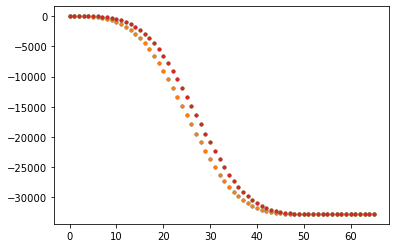

In [90]:
def feed(dut, x, r, g):
    yield dut.rate.eq(r)
    yield dut.gain_shift.eq(g)
    yield dut.rate_stb.eq(1)
    yield
    yield dut.rate_stb.eq(0)
    while x:
        xi = x.pop(0)
        yield dut.x.eq(xi)
        yield
        while not (yield dut.x_ack):
            yield
        for i in range(ch - 1):
            assert (yield dut.x_ack)
            yield
    return
    yield dut.x.eq(0)
    yield dut.rate_stb.eq(1)
    yield
    yield dut.rate_stb.eq(0)
    for i in range(20):
        yield

def record(dut, y):
    yield "passive"
    while True:
        yj = (yield dut.yi)
        yi = (yield dut.y)
        y[yj].append(yi)
        yield

ch = 4
rate = 16
order = 3
width = 16
g = math.ceil(order*math.log2(rate))
dut = CIC(width=width, channels=ch, rate_width=4, order=order)
print(g, len(dut.gain_shift))

x = [0] * 2 + [-1<<15] * 4
y = [[] for _ in range(ch)]
migen.sim.run_simulation(dut, [feed(dut, x[:], rate - 1, g), record(dut, y)], vcd_name="cic.vcd")
# print(y)
for yi in y:
    del yi[min(len(yi) for yi in y):]
plt.plot(np.array(y).T, ".");